In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
print(sys.version)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [ ]:
!pip install librosa tensorflow==2.12.0

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
orbax-checkpoint 0.11.12 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=

In [ ]:
import tensorflow as tf; print(tf.__version__)

2.12.0


In [ ]:
import tensorflow as tf
import librosa
import os
import joblib
import numpy as np
from matplotlib import pyplot as plt

BATCH_SIZE = 4
SAMPLE_RATE = 44100
TARGET_SAMPLE_RATE = 16000
DURATION = 3
N_MELS = 300
N_FFT = 1024
HOP_LENGTH = int((TARGET_SAMPLE_RATE * DURATION) / 1400)

def load_sound(filename):
    file_path = filename
    if (isinstance(filename,tf.Tensor)):
        file_path = filename.numpy().decode('utf-8')

    wav, sr = librosa.load(file_path, sr=TARGET_SAMPLE_RATE)
    wav = librosa.util.fix_length(wav, size=TARGET_SAMPLE_RATE * DURATION)

    return wav

def create_spectrogram(file_path, label):
    wav = load_sound(file_path)
    mel_spectrogram = librosa.feature.melspectrogram(
        y=wav, sr=TARGET_SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH, fmax=8000
    )
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    num_frames = mel_spectrogram.shape[1]

    if num_frames < 1400:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, 1400 - num_frames)), mode='constant')
    elif num_frames > 1400:
        mel_spectrogram = mel_spectrogram[:, :1400]

    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=-1)
    return mel_spectrogram, label

base_dir = '/content/drive/MyDrive/house_sounds/sound_data_1200'
folders = ['door', 'voice', 'glass', 'silence', 'dog', 'footsteps']

files = []
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    file_paths = tf.data.Dataset.list_files(os.path.join(folder_path, '*.mp3'))
    files.append(file_paths)

door = tf.data.Dataset.zip((files[0], tf.data.Dataset.from_tensor_slices(tf.fill([len(files[0])], 0))))
voice = tf.data.Dataset.zip((files[1], tf.data.Dataset.from_tensor_slices(tf.fill([len(files[1])], 1))))
glass = tf.data.Dataset.zip((files[2], tf.data.Dataset.from_tensor_slices(tf.fill([len(files[2])], 2))))
silence = tf.data.Dataset.zip((files[3], tf.data.Dataset.from_tensor_slices(tf.fill([len(files[3])], 3))))
dog = tf.data.Dataset.zip((files[4], tf.data.Dataset.from_tensor_slices(tf.fill([len(files[4])], 4))))
footsteps = tf.data.Dataset.zip((files[5], tf.data.Dataset.from_tensor_slices(tf.fill([len(files[5])], 5))))

data = door.concatenate(voice).concatenate(glass).concatenate(silence).concatenate(dog).concatenate(footsteps)

In [ ]:
total_files = sum([len(files) for files in files])
print(f"Total fișiere: {total_files}")

Total fișiere: 7200


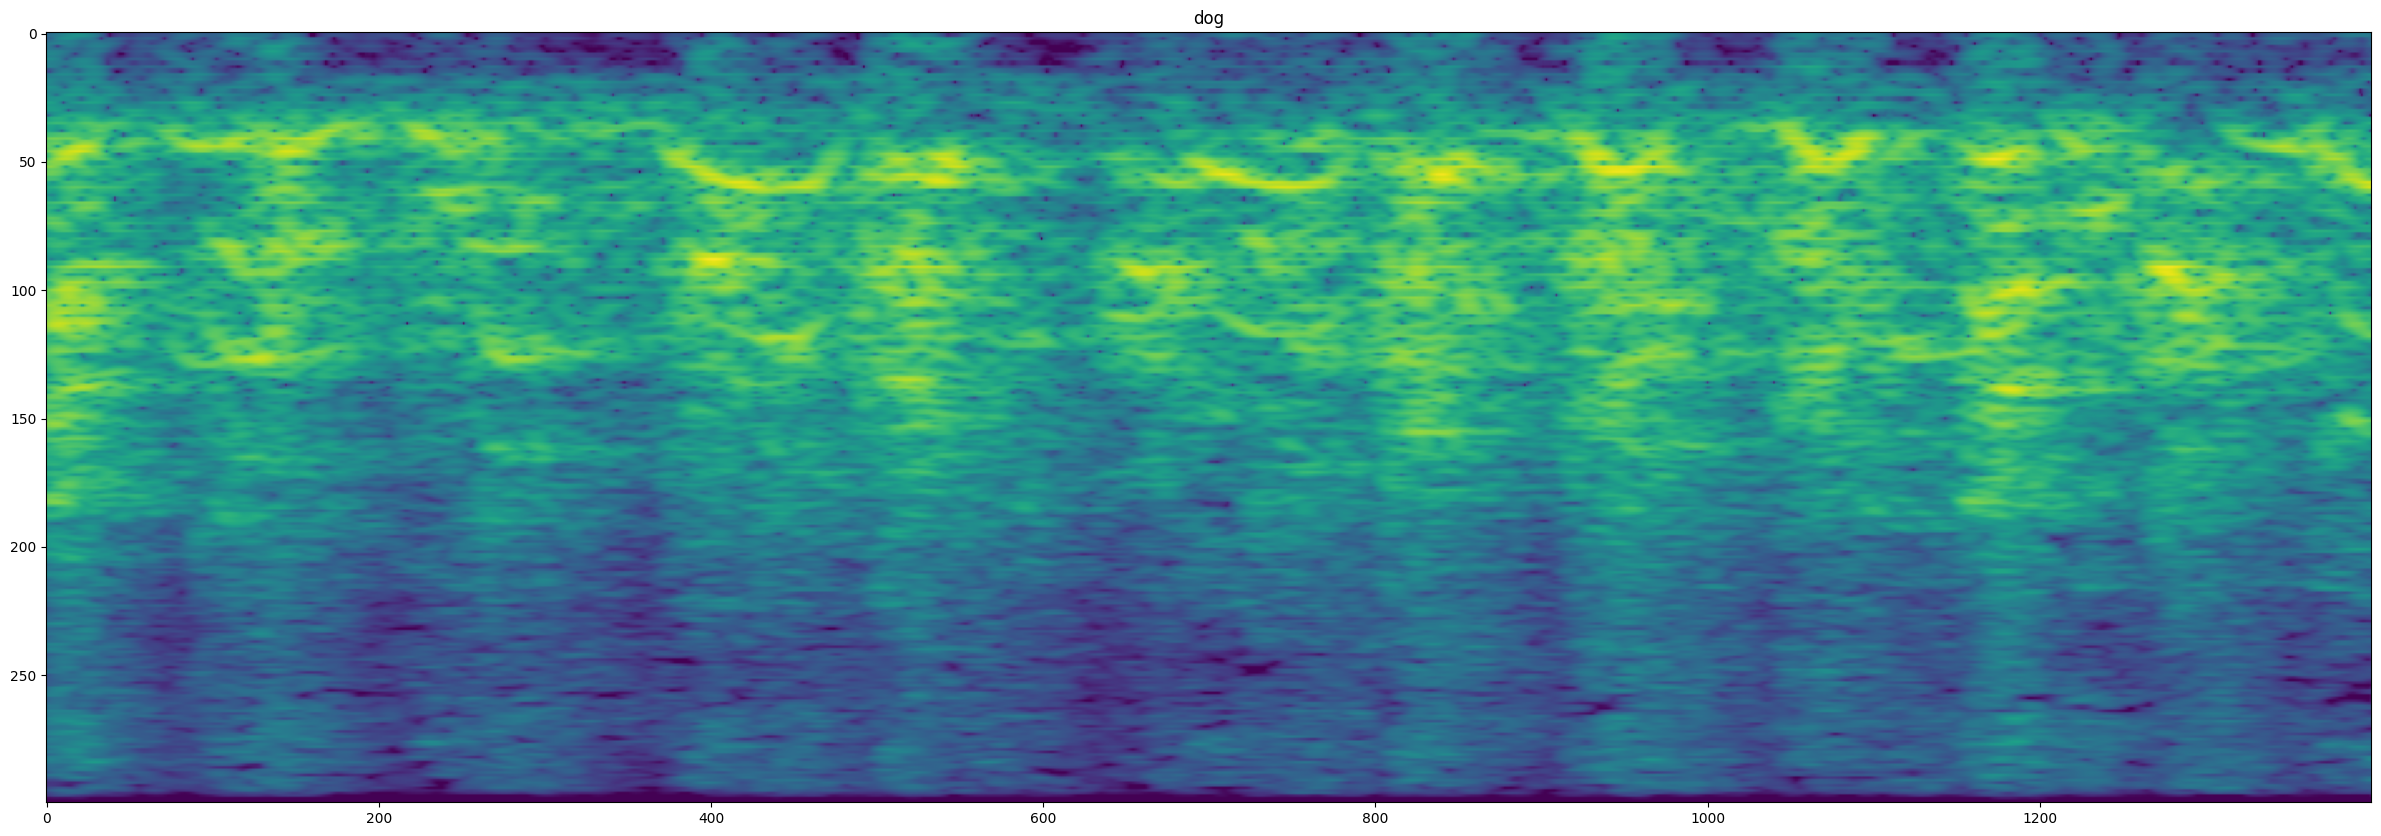

[[-53.52436  -52.85376  -51.979103 ... -47.55615  -48.028786 -48.89882 ]
 [-52.491158 -51.820557 -50.9459   ... -46.52294  -46.995583 -47.865616]
 [-54.64183  -54.892254 -54.23118  ... -55.465374 -53.6045   -51.60083 ]
 ...
 [-67.63858  -66.43994  -65.36238  ... -80.       -80.       -77.47986 ]
 [-78.635086 -78.07684  -77.63833  ... -80.       -80.       -79.97007 ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]

4


In [ ]:
f_path, l_abel = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = create_spectrogram(f_path, l_abel)
plt.figure(figsize=(30, 10))
plt.imshow(spectrogram[:, :, 0], cmap='viridis', aspect='auto')
plt.title(folders[label])
plt.show()
spectrogram.shape = (N_MELS, 1400, 1)
spectrogram = np.squeeze(spectrogram)
print(spectrogram)
print()
print(label)

In [ ]:
def process_data(file_path, label):
    spectrogram, label = tf.py_function(func=create_spectrogram, inp=[file_path, label], Tout=(tf.float32, tf.int32))
    spectrogram.set_shape([N_MELS, 1400, 1])
    label.set_shape([])
    return spectrogram, label

data = data.map(process_data)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(BATCH_SIZE)
data = data.prefetch(8)

print('Len:', len(data))
print('Cardinality:', data.cardinality().numpy())

Len: 1800
Cardinality: 1800


In [ ]:
train = data.take(1700)
test = data.skip(1700).take(100)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(N_MELS, 1400, 1)),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),
    Conv2D(40, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(32,activation="relu"),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

'''
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(N_MELS, 1400, 1)),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0,3),
    Flatten(),
    Dense(32, activation='relu',),
    Dense(6, activation='softmax')
])
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 1397, 32)     544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 465, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 465, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 463, 40)       11560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 154, 40)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 154, 40)       0

"\nmodel = Sequential([\n    Conv2D(16, (3, 3), activation='relu', input_shape=(N_MELS, 1400, 1)),\n    MaxPooling2D(pool_size=(3, 3)),\n    Dropout(0.2),\n    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),\n    MaxPooling2D(pool_size=(3, 3)),\n    Dropout(0.3),\n    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),\n    MaxPooling2D(pool_size=(3, 3)),\n    Dropout(0,3),\n    Flatten(),\n    Dense(32, activation='relu',),\n    Dense(6, activation='softmax')\n])\n"

In [ ]:
hist = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
1700/1700 [==============================] - 3692s 2s/step - loss: 1.0118 - accuracy: 0.8637 - val_loss: 3.8522 - val_accuracy: 0.7325
Epoch 2/5
1700/1700 [==============================] - 1916s 1s/step - loss: 0.7248 - accuracy: 0.8203 - val_loss: 1.0205 - val_accuracy: 0.7125
Epoch 3/5
1700/1700 [==============================] - 1904s 1s/step - loss: 0.5712 - accuracy: 0.7928 - val_loss: 12.8186 - val_accuracy: 0.7025
Epoch 4/5
1700/1700 [==============================] - 1908s 1s/step - loss: 0.6657 - accuracy: 0.7624 - val_loss: 245.0826 - val_accuracy: 0.0325
Epoch 5/5
1700/1700 [==============================] - 1907s 1s/step - loss: 0.5590 - accuracy: 0.7926 - val_loss: 67.3846 - val_accuracy: 0.0575


In [ ]:
model.save('/content/drive/MyDrive/house_sounds/AI_new_1c_mel_librosa_1200_1400x300_model')
model.save_weights('/content/drive/MyDrive/house_sounds/AI_new_1c_mel_librosa_1200_1400x300_weights.h5')
joblib.dump(folders, '/content/drive/MyDrive/house_sounds/AI_new_1c_mel_class_1200_labels.pkl')

test_loss, test_accuracy = model.evaluate(test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")